# Importando as bibliotecas

In [2]:
import numpy as np 
import pandas as pd
from os import walk
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson as poisson_scipy
from lmfit import Model


In [ ]:
### Descobrindo o nome dos arquivos  que contem as diferentes medidass

In [3]:
_, _, filenames = next(walk('geiger1'))

In [ ]:
## Calculando a média experimental, error, e variancia e colocando em um arquivo

In [5]:
def var_experimental(X):
   return  (len(X)-1)**-1.*sum((X-X.mean())**2)

In [6]:
STATS=np.zeros((len(filenames),3))

for i in range(len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    STATS[i,0]=data.mean()
    STATS[i,1]=(data.mean()/len(data))**0.5
    STATS[i,2]=var_experimental(data)

df=pd.DataFrame(STATS, columns=['media','erro_media','variancia'])
df.index=filenames
# df.to_csv('media_variancia.txt', sep=' ')

# Plotando a Distribuição sem nenhum fit

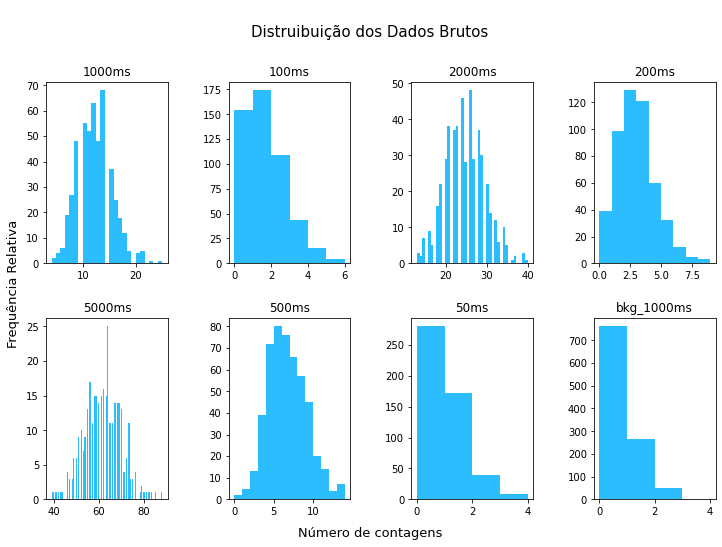

In [71]:
Blue = '#2CBDFE'

fig, ax=plt.subplots(2,4,figsize=(12,8))
for i in range(len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    dt=filenames[i].split('.')[0]
    ax[int(i/4),int(i%4)].hist(data,bins=int(max(data)),color=Blue)
    ax[int(i/4),int(i%4)].set_title(dt)
fig.suptitle('\nDistruibuição dos Dados Brutos',fontsize=15)
fig.text(0.5, 0.06, 'Número de contagens', ha='center',fontsize=13)
fig.text(0.08, 0.5, 'Frequência Relativa', va='center', rotation='vertical',fontsize=13)
plt.subplots_adjust( wspace=0.5, hspace=0.3,top=0.85)
plt.savefig('img\\fig_dist_dados_brutos_v1.png')


# Definindo funções que serão fitadas

In [8]:
# Poisson distribution
#std=mean

def poisson(x,lamb):
   return  poisson_scipy.pmf(x,lamb)

# Gaussian distribution

#std=mean

def gaussian(x,mean):
    return (np.pi*2.*mean)**-0.5*np.exp(-(x-mean)**2./(2.*mean))
 

def chi_2_over_freedom_degrees(Y_measured,Y_function,N_mesuments,n_parameters):
    index_nonzero=np.nonzero(Y_measured)
    chi2=np.sum((Y_measured[index_nonzero]-Y_function[index_nonzero])**2./Y_measured[index_nonzero]**2.)*(N_mesuments)/(N_mesuments-n_parameters)

    return  chi2

gaussian_vec=np.vectorize(gaussian)
poisson_vec=np.vectorize(poisson)

# Fit Distribuição de Poisson

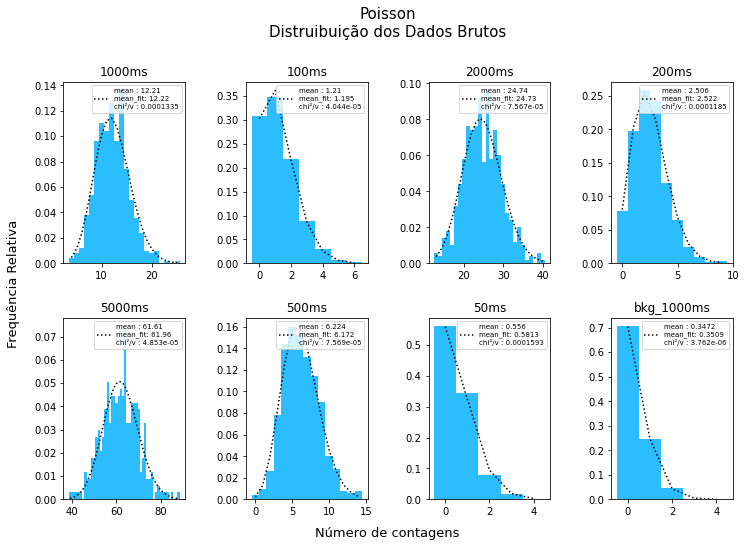

In [76]:
###poisson chi2

Blue = '#2CBDFE'
chi_poisson_per_dof=np.zeros(len(filenames))
parameters_poisson=np.zeros(len(filenames))
fig, ax=plt.subplots(2,4,figsize=(12,8))
for i in range(0,len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    dt=filenames[i].split('.')[0]

    X=np.arange(int(min(data))-1,int(max(data))+1)+0.5  
    mean=STATS[i,0]
    var=mean


    freq,bin_edges,_=ax[int(i/4),int(i%4)].hist(data,bins=X,color=Blue,density=True)
    bin_middles=0.5 * (bin_edges[1:] + bin_edges[:-1])
    poisson_model=Model(poisson)
    result=poisson_model.fit(freq,x=bin_middles,lamb=mean)
    parameter=result.best_values['lamb']
    chi2=result.redchi
    chi_poisson_per_dof[i]=chi2
    ax[int(i/4),int(i%4)].plot(bin_middles,poisson_vec(bin_middles,parameter),linestyle='dotted',color='black',label='mean : {:.4}\nmean_fit: {:.4}\nchi²/v : {:.4}'.format(mean,parameter,chi2))
    parameters_poisson[i]=parameter
    ax[int(i/4),int(i%4)].legend(fontsize=7)
    ax[int(i/4),int(i%4)].set_title(dt)
fig.suptitle('Poisson\nDistruibuição dos Dados Brutos',fontsize=15)
fig.text(0.5, 0.06, 'Número de contagens', ha='center',fontsize=13)
fig.text(0.06, 0.5, 'Frequência Relativa', va='center', rotation='vertical',fontsize=13)
plt.subplots_adjust( wspace=0.5, hspace=0.3,top=0.85)

# plt.savefig('img\\fig_poisson_minimos_quad_dist_dados_brutos_v1.png')


# Fit Distribuição de Gauss

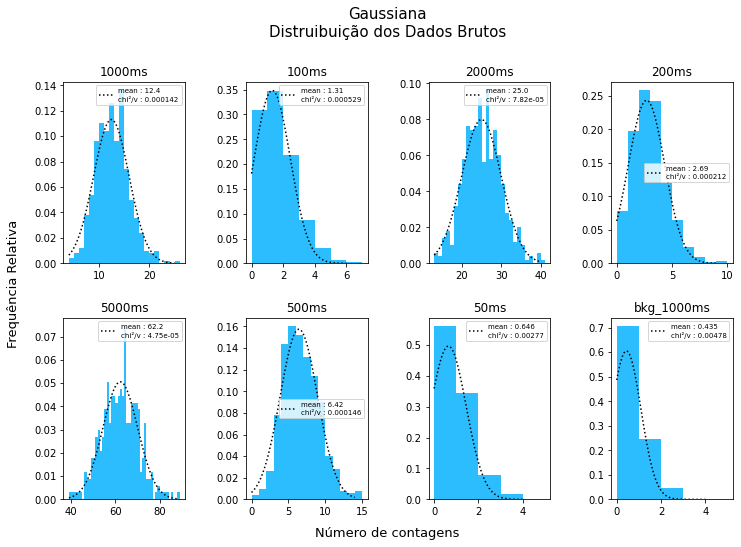

In [73]:
Blue = '#2CBDFE'
chi_gaussian_per_dof=np.zeros(len(filenames))
parameters_gaussian=np.zeros(len(filenames))
fig, ax=plt.subplots(2,4,figsize=(12,8))
for i in range(len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    dt=filenames[i].split('.')[0]
    mean=STATS[i,0] # valor da média que eu já tinah calculado
    var=STATS[i,2]# valor da variancia que eu já tinha calculado


    X=np.linspace(min(data),max(data),100)

    BIN=np.arange(int(min(data)),int(max(data))+2)  
    
    freq,bin_edges,_=ax[int(i/4),int(i%4)].hist(data,bins=BIN,color=Blue,density=True)
    bin_middles=0.5 * (bin_edges[1:] + bin_edges[:-1])


    gaussian_model=Model(gaussian)
    result=gaussian_model.fit(freq,x=bin_middles,mean=mean)
    chi2=result.redchi
    chi_gaussian_per_dof[i]=chi2
    parameter=result.best_values['mean']
    parameters_gaussian[i]=parameter

    ax[int(i/4),int(i%4)].plot(X,gaussian(X,parameter),linestyle='dotted',color='black',label='mean : {:.3}\nchi²/v : {:.3}'.format(parameter,chi2))
    ax[int(i/4),int(i%4)].legend(fontsize=7)
    ax[int(i/4),int(i%4)].set_title(dt)
fig.suptitle('Gaussiana\nDistruibuição dos Dados Brutos',fontsize=15)
fig.text(0.5, 0.06, 'Número de contagens', ha='center',fontsize=13)
fig.text(0.06, 0.5, 'Frequência Relativa', va='center', rotation='vertical',fontsize=13)
plt.subplots_adjust( wspace=0.5, hspace=0.3,top=0.85)

# plt.savefig('img\\fig_gaussiana_minimos_quad_dist_dados_brutos_v1.png')


# Escolha do melhor fit baseado no Chi²/dof

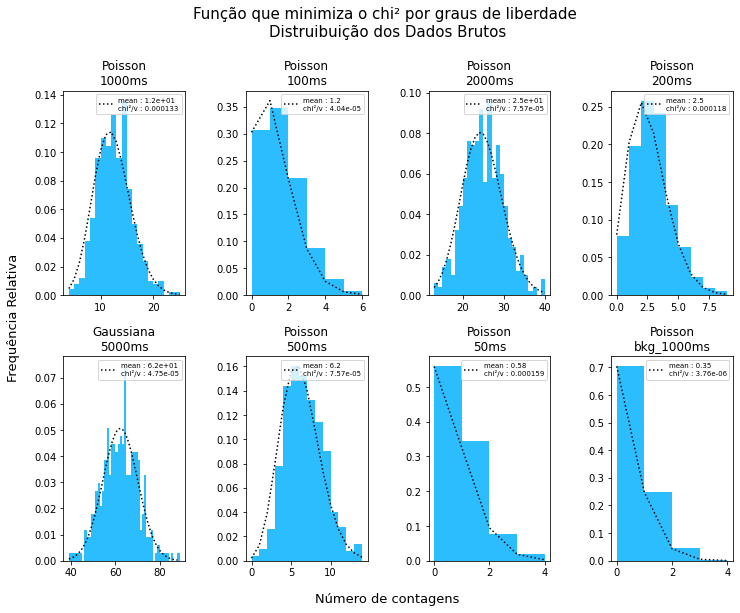

In [74]:
fig, ax=plt.subplots(2,4,figsize=(12,9))

for i in range(len(filenames)):
    data=np.loadtxt('geiger1/'+filenames[i])[:,1]
    mean=STATS[i,0]
    dt=filenames[i].split('.')[0]

    if chi_poisson_per_dof[i]<chi_gaussian_per_dof[i]:
            X=np.arange(int(min(data)),int(max(data))+1)
            ax[int(i/4),int(i%4)].plot(X,poisson(X,parameters_poisson[i]),linestyle='dotted',color='black',label='mean : {:.2}\nchi²/v : {:.3}'.format(parameters_poisson[i],chi_poisson_per_dof[i]))
            ax[int(i/4),int(i%4)].hist(data,bins=X,color=Blue,density=True)
            ax[int(i/4),int(i%4)].legend(fontsize=7)
            ax[int(i/4),int(i%4)].set_title('Poisson\n'+dt)

    else:
            std=mean**0.5
            X=np.linspace(min(data),max(data),100)
            ax[int(i/4),int(i%4)].plot(X,gaussian(X,parameters_gaussian[i]),linestyle='dotted',color='black',label='mean : {:.2}\nchi²/v : {:.3}'.format(parameters_gaussian[i],chi_gaussian_per_dof[i]))
            BIN=np.arange(int(min(data)),int(max(data))+2)  
            ax[int(i/4),int(i%4)].hist(data,bins=BIN,color=Blue,density=True)
            ax[int(i/4),int(i%4)].legend(fontsize=7)
            ax[int(i/4),int(i%4)].set_title('Gaussiana\n'+dt)
fig.suptitle('Função que minimiza o chi² por graus de liberdade \nDistruibuição dos Dados Brutos',fontsize=15)
fig.text(0.5, 0.06, 'Número de contagens', ha='center',fontsize=13)
fig.text(0.06, 0.5, 'Frequência Relativa', va='center', rotation='vertical',fontsize=13)
plt.subplots_adjust( wspace=0.5, hspace=0.3,top=0.85)

# plt.savefig('img\\fig_melhor_funcao_chi2_dist_dados_brutos_v1.png')


In [79]:
dt=[int(filenames[i].split('ms')[0]) for i in range(len(filenames)-1)]
dt

[1000, 100, 2000, 200, 5000, 500, 50]

In [80]:
decay_rate=np.vstack((STATS[:-1,0]/dt,STATS[:-1,1]/dt))
decay_rate=decay_rate.transpose()
decay_rate

array([[1.22080000e-02, 1.56256200e-04],
       [1.21000000e-02, 4.91934955e-04],
       [1.23720000e-02, 1.11229492e-04],
       [1.25300000e-02, 3.53977400e-04],
       [1.23220238e-02, 8.56419172e-05],
       [1.24480000e-02, 2.23141211e-04],
       [1.11200000e-02, 6.66933280e-04]])

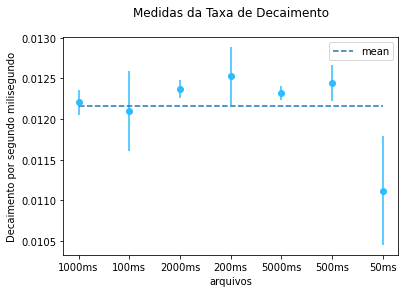

In [81]:
labels=[filenames[i].split('.')[0] for i in range(len(filenames)-1)]
plt.errorbar(labels,decay_rate[:,0],yerr=decay_rate[:,1],color=Blue,fmt='o')
mean_decays=np.ones(7)*decay_rate[:,0].mean()
plt.plot(labels,mean_decays,linestyle='dashed',label='mean')
error_mean=(decay_rate[:,0].mean()/len(dt))**0.5
# plt.fill_between(labels,mean_decays-error_mean,mean_decays+error_mean)
plt.title('Medidas da Taxa de Decaimento\n')
plt.xlabel('arquivos')
plt.ylabel('Decaimento por segundo milisegundo')
plt.legend()

In [82]:
ccd_data=np.loadtxt('ativo1.txt')
ccd_overscan=np.loadtxt('overscan.txt')

Text(0.5, 1.0, 'Ativo 1')

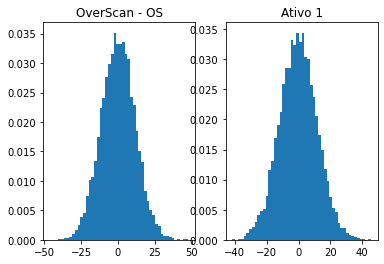

In [83]:
fig,ax=plt.subplots(1,2)
ax[0].hist(ccd_overscan,bins=50,density=True)
ax[0].set_title('OverScan - OS')
ax[1].hist(ccd_data,bins=50,density=True)
ax[1].set_title('Ativo 1')

In [96]:
STATS_overscan=np.zeros((len(ccd_overscan)-2,3))

for i in range(1,len(ccd_overscan)-1):
    data=ccd_overscan[:i*2]
    mean=data.mean()
    var=data.var()
    error_mean=(np.abs(mean)/i*2.)**0.5

    STATS_overscan[i-1,:]=[mean,error_mean,var]


In [97]:
STATS_overscan

array([[ 6.65050000e-01,  1.15329961e+00,  1.93737169e+02],
       [-9.33780000e+00,  3.05578141e+00,  2.12565578e+02],
       [-8.79161133e+00,  2.42096556e+00,  1.59868322e+02],
       ...,
       [ 1.09781308e-01,  4.27819887e-03,  1.32892156e+02],
       [ 1.09781308e-01,  4.27802057e-03,  1.32892156e+02],
       [ 1.09781308e-01,  4.27784228e-03,  1.32892156e+02]])

Text(0.5, 0, 'Metade da Quantidade de dados')

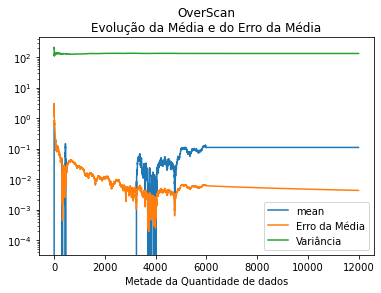

In [105]:
plt.plot(np.arange(2,2+len(STATS_overscan[:,0])),STATS_overscan[:,0],label='mean')
plt.plot(np.arange(2,2+len(STATS_overscan[:,1])),STATS_overscan[:,1],label='Erro da Média')
plt.plot(np.arange(2,2+len(STATS_overscan[:,2])),STATS_overscan[:,2],label='Variância')

plt.yscale('log')
plt.legend()
plt.title('OverScan\nEvolução da Média e do Erro da Média')
plt.xlabel('Metade da Quantidade de dados')

In [102]:
STATS_active=np.zeros((len(ccd_data)-2,3))

for i in range(1,len(ccd_data)-1):
    data=ccd_data[:i*2]
    mean=data.mean()
    var=data.var()
    error_mean=(np.abs(mean)/i*2.)**0.5

    STATS_active[i-1,:]=[mean,error_mean,var]


Text(0.5, 0, 'Metade da Quantidade de dados')

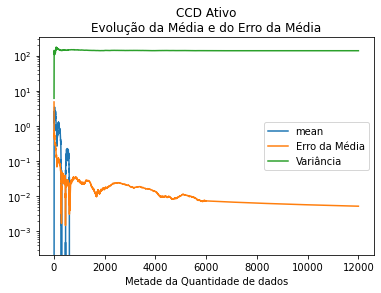

In [107]:
plt.plot(np.arange(2,2+len(STATS_active[:,0])),STATS_active[:,0],label='mean')
plt.plot(np.arange(2,2+len(STATS_active[:,1])),STATS_active[:,1],label='Erro da Média')
plt.plot(np.arange(2,2+len(STATS_active[:,1])),STATS_active[:,2],label='Variância')

plt.yscale('log')
plt.legend()
plt.title('CCD Ativo\nEvolução da Média e do Erro da Média')
plt.xlabel('Metade da Quantidade de dados')